In [22]:


import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython
import IPython.display

# Load the dataset from CSV file
og_df = pd.read_csv('data/Structured/all_data.csv')

C:\Users\albin\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3442: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [33]:

df = og_df.dropna(axis=1, how='all')
df.drop(['Summa gas/Diesel'], axis=1, inplace=True)

df = df.fillna(method='ffill')
df = df.fillna(method='bfill')
for e in df.columns:
    if df[e].nunique() == 1:
        df = df.drop(e, axis=1)
  
first_column = df.pop('SE1')
df.insert(1, 'SE1', first_column)


c:\Users\albin\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\albin\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3382: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if await self.run_code(code, result, async_=asy):


In [34]:

test_end = df[df['Date'] == '2019-01-01 23:00:00'].index.values[0]
df.drop(['Date'], axis=1, inplace=True)

# df = df.iloc[:,0:5]

n_features = df.shape[1]-1

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])


# Split the dataset into training and testing sets
test_size = int(len(df) * 0.1)

train_df = df[:test_end-test_size]
train_df = pd.concat([train_df, df[test_end:]])
test_df = df[test_end-test_size:test_end]
print(train_df.shape)
print(test_df.shape)

(182591, 470)
(20287, 470)


In [35]:
# Define the sequence length for the LSTM model
sequence_length = 10

def create_sequences(df, sequence_length):
    X = []
    y = []
    for i in range(len(df) - sequence_length):
        X.append(df.iloc[i:i+sequence_length, 1:].values)
        y.append(df.iloc[i+sequence_length, 0])
    return np.array(X), np.array(y)


X_train, y_train = create_sequences(train_df, sequence_length)
X_test, y_test = create_sequences(test_df, sequence_length)
print(X_train.shape)
print(X_test.shape)

(182581, 10, 469)
(20277, 10, 469)


[0.01070585 0.01070585 0.01070585 ... 0.00479126 0.00153841 0.00305148]
(182581,)


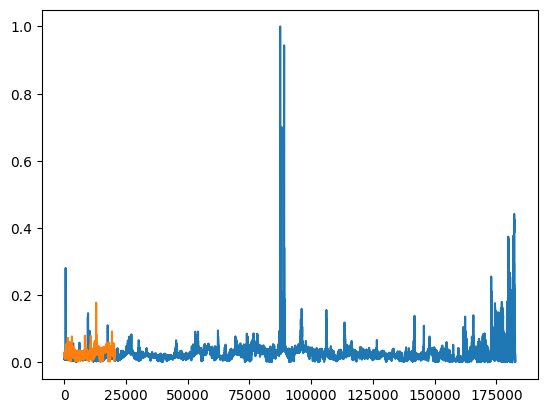

In [36]:
print(y_train)
print(y_train.shape)
plt.plot(y_train)

plt.plot(y_test)

In [37]:

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(sequence_length, n_features), return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Normalization(),
    tf.keras.layers.LSTM(32, input_shape=(sequence_length, n_features)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])


In [38]:

class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        IPython.display.clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [43]:

def compile_and_fit(model, X_train, y_train, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])

  history = model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=1, validation_split=0.1,
                      callbacks=[early_stopping, PlotLearning()])
  return history

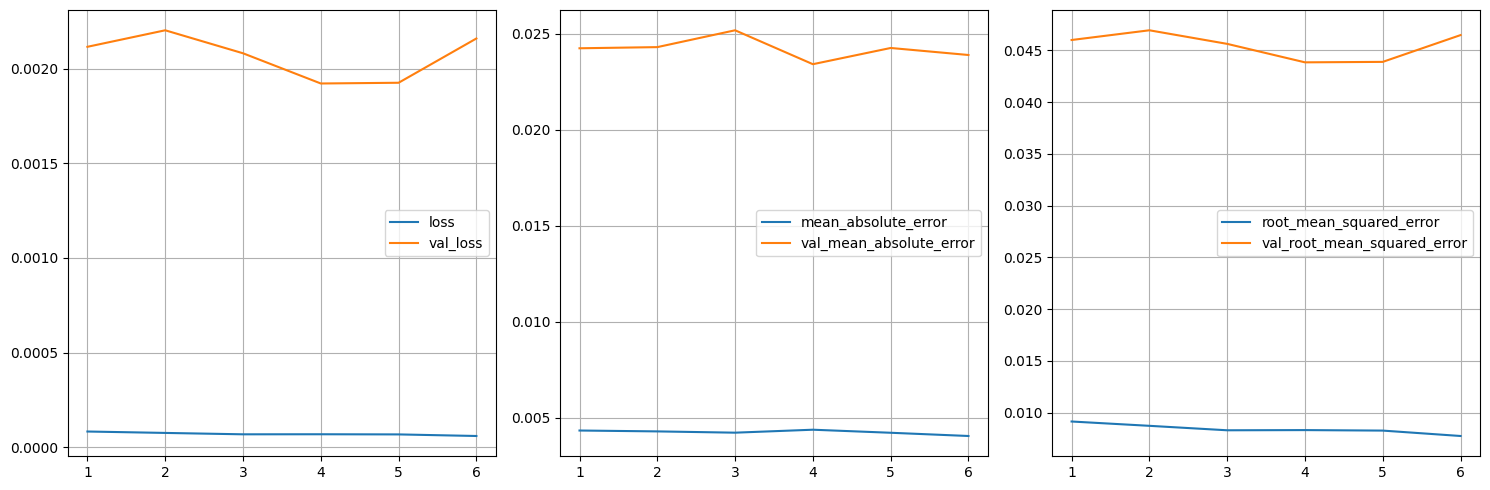

1284/1284 [==============================] - 128s 100ms/step - loss: 6.0079e-05 - mean_absolute_error: 0.0040 - root_mean_squared_error: 0.0078 - val_loss: 0.0022 - val_mean_absolute_error: 0.0239 - val_root_mean_squared_error: 0.0465
Test loss: [8.281219197669998e-05, 0.006510818377137184, 0.009100120514631271]


In [44]:

history = compile_and_fit(model, X_train, y_train)

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', loss)

In [45]:
result = model.predict(X_test)

634/634 [==============================] - 17s 25ms/step


(20277, 1)
[[0.01964929]
 [0.01921749]
 [0.0191454 ]
 ...
 [0.02138635]
 [0.02140702]
 [0.02104482]]


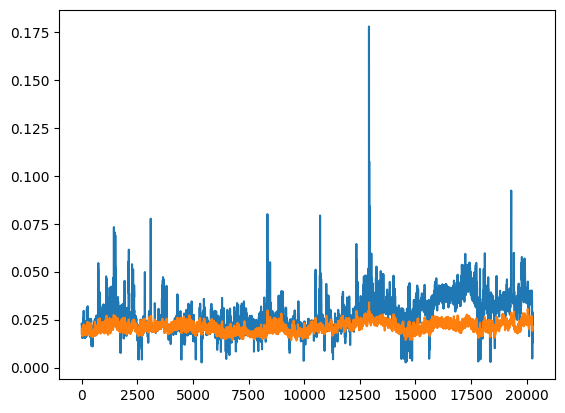

In [46]:

print(result.shape)
print(result)
plt.plot(y_test)
plt.plot(result)